### [Hypermarameter Tuning](https://scikit-learn.org/stable/modules/grid_search.html)

- Hyper-parameters are parameters that are not directly learnt within estimators. In scikit-learn they are passed as arguments to the constructor of the estimator class. Examples include `C`, `kernel` and `gamma` for *Support Vector Classifier*, `alpha` for *Lasso*, etc.

- Use `estimator.get_params()` to get the names & current values of all parameters in an estimator.

- Scikit-Learn has two approaches to parameter search: **GridSearchCV** exhaustively considers all combinations; **RandomizedSearchCV** samples  candidates from a parameter space with a specified distribution. 

- Both have *successive halving counterparts* **HalvingGridSearchCV** and **HalvingRandomSearchCV**, which can be much faster.

- A small subset of those parameters can have a large impact while others can be left to their default values.

### [Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)

- Exhaustively generates candidates from a grid of values specified by `param_grid`.

### [Randomized Param Optimization](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV)

- While *grid search* is the most popular method for parameter optimization, **RandomizedSearchCV** searches each setting by sampling a distribution over its possible values. This has two benefits:

    - A budget can be chosen independent of the #parameters and possible values.
    
    - Adding parameters that do not influence the performance does not decrease efficiency.

- Parameters are chosen with a *dictionary* plus a *computation budget*, (a #sampled candidates or sampling iterations) with `n_iter`. 

- Supply either a distribution or list of choices (which will be sampled uniformly): `{'C': scipy.stats.expon(scale=100), 'gamma': scipy.stats.expon(scale=.1),
  'kernel': ['rbf'], 'class_weight':['balanced', None]}`
  
- Specify a continuous distribution to use randomization with continuous variables such as `C`.

- A continuous log-uniform random variable is available through `loguniform`. For example, *loguniform(1, 100)* can be used instead of [1, 10, 100] or np.logspace(0, 2, num=1000). This is an alias to *SciPy’s stats.reciprocal*.

- Mirroring the example above in grid search, we can specify a continuous random variable that is log-uniformly distributed between 1e0 and 1e3:

In [15]:
from sklearn.utils.fixes import loguniform
{'C': loguniform(1e0, 1e3),
 'gamma': loguniform(1e-4, 1e-3),
 'kernel': ['rbf'],
 'class_weight':['balanced', None]}

{'C': <scipy.stats._distn_infrastructure.rv_frozen at 0x7fd48b999160>,
 'gamma': <scipy.stats._distn_infrastructure.rv_frozen at 0x7fd48b95eb20>,
 'kernel': ['rbf'],
 'class_weight': ['balanced', None]}

### [Example: Grid Search with Cross Validation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py)

In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split as TTS
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report as CR
from sklearn.svm import SVC

In [2]:
# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix

digits = datasets.load_digits()
n_samples = len(digits.images)
X,y = digits.images.reshape((n_samples, -1)), digits.target

X_train, X_test, y_train, y_test = TTS(
    X, y, test_size=0.5, random_state=0)

tuned_parameters = [{'kernel': ['rbf'], 
                     'gamma' : [1e-3, 1e-4],
                     'C'     : [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 
                     'C'     : [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

In [3]:
for score in scores:
    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("best params:\t",clf.best_params_)

    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    print("Grid scores:\t")
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))

    print("Detailed classification report:")
    y_true, y_pred = y_test, clf.predict(X_test)
    print(CR(y_true, y_pred))

best params:	 {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Grid scores:	
0.986 (+/-0.016) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.959 (+/-0.028) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.982 (+/-0.026) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.983 (+/-0.026) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.983 (+/-0.026) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.974 (+/-0.012) for {'C': 1, 'kernel': 'linear'}
0.974 (+/-0.012) for {'C': 10, 'kernel': 'linear'}
0.974 (+/-0.012) for {'C': 100, 'kernel': 'linear'}
0.974 (+/-0.012) for {'C': 1000, 'kernel': 'linear'}
Detailed classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        89
           1       0.97      1.00      0.98        90
        

### [Example: PCA Complexity vs Cross-Validated Accuracy](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_refit_callable.html#sphx-glr-auto-examples-model-selection-plot-grid-search-refit-callable-py)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

In [5]:
def lower_bound(cv_results):
    """
    Calculate the lower bound within 1 standard deviation
    of the best `mean_test_scores`.

    Parameters
    ----------
    cv_results : dict of numpy(masked) ndarrays
        See attribute cv_results_ of `GridSearchCV`

    Returns
    -------
    float
        Lower bound within 1 standard deviation of the
        best `mean_test_score`.
    """
    best_score_idx = np.argmax(cv_results['mean_test_score'])

    return (cv_results['mean_test_score'][best_score_idx]
            - cv_results['std_test_score'][best_score_idx])

# params: cv_results (dict of numpy maskset naarrays)
# returns: model index with fewest PCA components with test score <1 stdev 
#          of best `mean_test_score

def best_low_complexity(cv_results):

    threshold     = lower_bound(cv_results)
    candidate_idx = np.flatnonzero(cv_results['mean_test_score'] >= threshold)
    best_idx      = candidate_idx[cv_results['param_reduce_dim__n_components']
                                  [candidate_idx].argmin()]
    return best_idx


pipe = Pipeline([
        ('reduce_dim', PCA(random_state=42)),
        ('classify',   LinearSVC(random_state=42, C=0.01)),
])

param_grid = {
    'reduce_dim__n_components': [6, 8, 10, 12, 14]
}

X, y = load_digits(return_X_y=True)

grid = GridSearchCV(pipe, cv=10, n_jobs=1, param_grid=param_grid,
                    scoring='accuracy', refit=best_low_complexity).fit(X, y)

n_components = grid.cv_results_['param_reduce_dim__n_components']
test_scores = grid.cv_results_['mean_test_score']

The best_index_ is 2
The n_components selected is 10
The corresponding accuracy score is 0.88


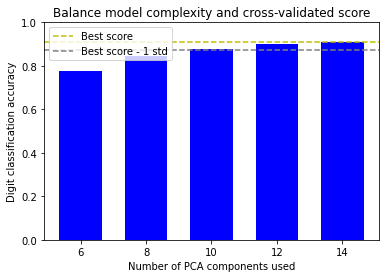

In [6]:
plt.figure()
plt.bar(n_components, test_scores, width=1.3, color='b')

lower = lower_bound(grid.cv_results_)

plt.axhline(np.max(test_scores), linestyle='--', color='y', label='Best score')
plt.axhline(lower, linestyle='--', color='.5', label='Best score - 1 std')

plt.title("Balance model complexity and cross-validated score")
plt.xlabel('Number of PCA components used')
plt.ylabel('Digit classification accuracy')
plt.xticks(n_components.tolist())
plt.ylim((0, 1.0))
plt.legend(loc='upper left')

best_index_ = grid.best_index_

print("The best_index_ is %d" % best_index_)
print("The n_components selected is %d" % n_components[best_index_])
print("The corresponding accuracy score is %.2f"
      % grid.cv_results_['mean_test_score'][best_index_])

### [Example: Random Search vs Grid Search](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py)


In [16]:
import numpy as np
from time import time
import scipy.stats as stats
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import GridSearchCV as GS
from sklearn.model_selection import RandomizedSearchCV as RS
from sklearn.datasets import load_digits
from sklearn.linear_model import SGDClassifier as SGDC

In [17]:
X, y = load_digits(return_X_y=True)

clf = SGDC(loss='hinge', penalty='elasticnet', fit_intercept=True)

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# specify parameters and distributions to sample from
param_dist = {'average': [True, False],
              'l1_ratio': stats.uniform(0, 1),
              'alpha': loguniform(1e-4, 1e0)}

# run randomized search
n_iter_search = 20
random_search = RS(clf, 
                   param_distributions=param_dist,
                   n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

# use a full grid over all parameters
param_grid = {'average': [True, False],
              'l1_ratio': np.linspace(0, 1, num=10),
              'alpha': np.power(10, np.arange(-4, 1, dtype=float))}

# run grid search
grid_search = GS(clf, param_grid=param_grid)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

/home/bjpcjp/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/home/bjpcjp/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/home/bjpcjp/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/home/bjpcjp/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration

RandomizedSearchCV took 24.49 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.920 (std: 0.031)
Parameters: {'alpha': 0.0006108341940380009, 'average': False, 'l1_ratio': 0.7389206483086175}

Model with rank: 2
Mean validation score: 0.919 (std: 0.035)
Parameters: {'alpha': 0.008490848548217928, 'average': False, 'l1_ratio': 0.3743915046152}

Model with rank: 3
Mean validation score: 0.918 (std: 0.036)
Parameters: {'alpha': 0.0003484324373622794, 'average': False, 'l1_ratio': 0.7747484234866344}



/home/bjpcjp/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/home/bjpcjp/.local/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


GridSearchCV took 91.15 seconds for 100 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.931 (std: 0.030)
Parameters: {'alpha': 1.0, 'average': True, 'l1_ratio': 0.0}

Model with rank: 2
Mean validation score: 0.928 (std: 0.027)
Parameters: {'alpha': 1.0, 'average': False, 'l1_ratio': 0.0}

Model with rank: 3
Mean validation score: 0.928 (std: 0.024)
Parameters: {'alpha': 0.0001, 'average': True, 'l1_ratio': 0.2222222222222222}



### Successive Halving for [Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html#sklearn.model_selection.HalvingGridSearchCV) and [Random Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html#sklearn.model_selection.HalvingRandomSearchCV)

- Successive halving (SH) is like a tournament among candidate parameter combinations. It is an iterative selection process where all parameter combinations are evaluated with a small amount of resources (typically training samples) at the first iteration. Only some of these candidates are selected for the next iteration, which will be allocated more resources. The resources can also be an arbitrary numeric parameter such as `n_estimators` in a random forest.

- Below: only a subset of candidates ‘survive’ until the last iteration. They have consistently ranked among the top-scoring candidates across all iterations. Each iteration is allocated an increasing amount of resources per candidate.

### [Example: Successive Halving Iterations](https://scikit-learn.org/stable/auto_examples/model_selection/plot_successive_halving_iterations.html)

In [18]:
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
from scipy.stats import randint
import numpy as np
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.ensemble import RandomForestClassifier

In [19]:
rng = np.random.RandomState(0)

X, y = datasets.make_classification(n_samples=700, random_state=rng)

clf = RandomForestClassifier(n_estimators=20, random_state=rng)

param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 11),
              "min_samples_split": randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

rsh = HalvingRandomSearchCV(
    estimator=clf,
    param_distributions=param_dist,
    factor=2,
    random_state=rng).fit(X, y)

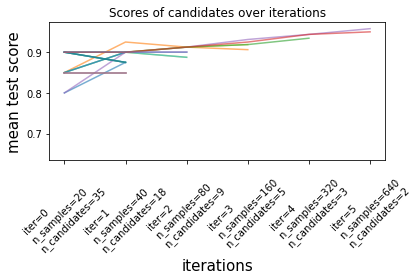

In [20]:
results = pd.DataFrame(rsh.cv_results_)
results['params_str'] = results.params.apply(str)

results.drop_duplicates(subset=('params_str', 'iter'), 
                        inplace=True)

mean_scores = results.pivot(index='iter', 
                            columns='params_str',
                            values='mean_test_score')

ax = mean_scores.plot(legend=False, alpha=.6)

labels = [
    f'iter={i}\nn_samples={rsh.n_resources_[i]}\n'
    f'n_candidates={rsh.n_candidates_[i]}'
    for i in range(rsh.n_iterations_)
]

ax.set_xticks(range(rsh.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment='left')
ax.set_title('Scores of candidates over iterations')
ax.set_ylabel('mean test score', fontsize=15)
ax.set_xlabel('iterations', fontsize=15)
plt.tight_layout()

- 1st iteration: a small amount of resources (#samples) is used. All candidates are evaluated.

- 2nd iteration: the best half of the candidates is evaluated. The number of allocated resources is doubled: candidates are evaluated on twice as many samples.

- last iteration: only 2 candidates are left. The best candidate is the candidate that has the best score at the last iteration.

### Tips

- Parameter search uses the estimator's `score` function by default. They are [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) and [r2 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score) for classification and regression respectively.

- Alternatives can specified using the `scoring` parameter of most search tools.

- You can use *multiple metrics* for Grid & Randomized searches. They are specified as a list of strings, or a name:function dict.

- When specifying multiple metrics, set `refit` to the metric for which `best_params_` will be used to build the `best_estimator_` for the entire dataset. Otherwise set `refit=False` - the default `refit=None` setting will cause errors when using multiple metrics.

- **Parallelism**: param search tools evaluate each data fold independently. Computations can run in parallel vis `n_jobs=-1`.

- **Robustness**: some settings can cause `fit` failures. This will cause the entire search to fail by default. Use `error_score=0` or `error_score=np.NaN` to instead issue a warning & set the score for that fold to zero or NaN.

### Composite Estimators & Parameter Spaces

- Grid & Randomized parameter search can use composite or nested estimators (Pipelines, Column Transformers, Voting Classifiers, Calibrated Classifiers). A dedicated syntax is involved.

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons

X, y = make_moons()

calibrated_forest = CalibratedClassifierCV(
   base_estimator=RandomForestClassifier(n_estimators=10))

param_grid = {
   'base_estimator__max_depth': [2, 4, 6, 8]}

search = GridSearchCV(calibrated_forest, 
                      param_grid, 
                      cv=5).fit(X, y)

- If the meta-estimator is build as a collection (ie, Pipeline), `estimator` refers to the estimator name. There can be multiple nesting levels.

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest

pipe = Pipeline([
   ('select', SelectKBest()),
   ('model', calibrated_forest)])

param_grid = {
   'select__k': [1, 2],
   'model__base_estimator__max_depth': [2, 4, 6, 8]}

search = GridSearchCV(pipe, param_grid, cv=5).fit(X, y)

### Alternative to Brute-Force Search

- Some models can fit data for a range of param values almost as efficiently as fitting an estimator for a single param value. The most common example of this is *regularization strength*. The following models have this capability.

- [ElasticNet CV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html#sklearn.linear_model.ElasticNetCV)
- [LARS CV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LarsCV.html#sklearn.linear_model.LarsCV)
- [Lasso CV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV)
- [LassoLARS CV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoLarsCV.html#sklearn.linear_model.LassoLarsCV)
- [Logistic Regression CV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV)
- [ElasticNet (Multitask) CV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.MultiTaskElasticNetCV.html#sklearn.linear_model.MultiTaskElasticNetCV)
- [Lasso (Multitask) CV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.MultiTaskLassoCV.html#sklearn.linear_model.MultiTaskLassoCV)
- [OMP CV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.OrthogonalMatchingPursuitCV.html#sklearn.linear_model.OrthogonalMatchingPursuitCV)
- [Ridge CV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV)
- [Ridge Classifier CV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifierCV.html#sklearn.linear_model.RidgeClassifierCV)

### Info Criteria (AIC, BIC) based Regularization

- [LassoLARS IC](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoLarsIC.html#sklearn.linear_model.LassoLarsIC) uses either the AIC or BIC info criterions to build optimal regularization estimates with a single regularization path (instead of building several via cross-validation.) 

### [Example: Model comparison w/ Grid Search](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html#sphx-glr-auto-examples-model-selection-plot-grid-search-stats-py)

- TODO